# Laboration deep learning AI21

## 0. EDA och filhantering

Creating the folders with python :

In [55]:
import os , random, shutil, glob 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
parent_dir = os.getcwd() #get actual directory
main_folders = ["experiment_small_data","experiment_tiny_data","original_data"]
subfolders = ["experiment_small_data/test","experiment_small_data/train","experiment_small_data/val","experiment_tiny_data/test","experiment_tiny_data/train","experiment_tiny_data/val","original_data/train","original_data/test"]

for main_f in main_folders :
    for sub_f in subfolders : 
        sub_f_list = sub_f.split("/") # turn subfolder path into list of folders
        if main_f in sub_f_list : 
            directory_name = sub_f_list[1] #actual directory to make is the 2nd in the list
            path = os.path.join(parent_dir,main_f,directory_name) #creating the folder path
            if not os.path.isdir(path): # check if path doesn't already exist
                try: 
                    os.makedirs(path) #create all missing folders in the folder path 
                except OSError as error: 
                    print(error)

Read in 10 pictures randomly and plot them out, use the label as plot title :

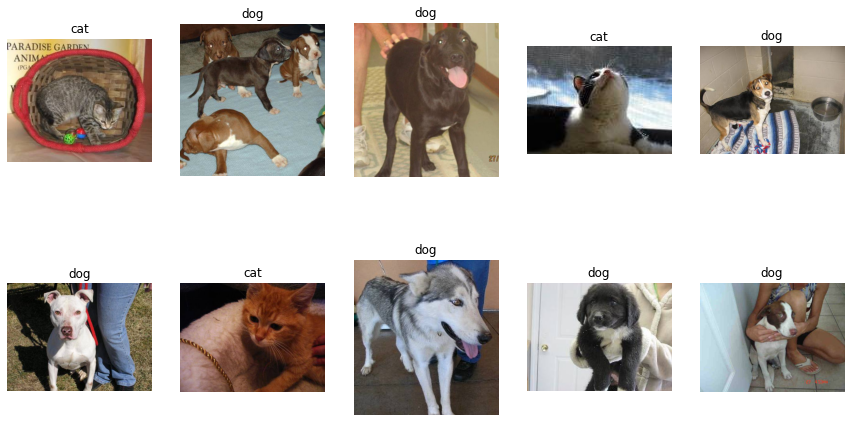

In [71]:
folder = "original_data/train/train" #source folder for all labeled images

files = random.sample(glob.glob(parent_dir+"/"+folder+"/*.jpg"), 10) # getting a random sample of 10 jpg files from directory

fig, axes = plt.subplots(2,5, figsize=(15,8))
for file_path,(i, ax) in zip(files,enumerate(axes.flatten())) : 
    label = file_path.split("/")[-1].split(".")[0] # getting the label from the path
    image = plt.imread(file_path) # read image with plt imread method
    ax.imshow(image) 
    ax.set_title(f"{label}")
    ax.axis("off")


Split the data into train / validation / test :

In [90]:
# splitting the data 

folder_for = lambda x : os.path.join(parent_dir,data,x) #creates folder path
source_folder = os.path.join(parent_dir,"original_data/train/train") # source of all pictures we will use for train|val|test

data_names = ["experiment_small_data","experiment_tiny_data"]
samples_sizes = [(800,200,250),(80,20,25)]

for data,sample_size in zip(data_names,samples_sizes): #loop simultaneously through folder names and samples size
    train_size,val_size, test_size = sample_size # pick the train,val,test sizes

    animal_list = lambda x : [x+"."+str(y)+".jpg" for y in random.sample(range(1,12500),sum(sample_size))] # returns a list of randomly picked files for a specific label
    cats = animal_list("cat") 
    dogs = animal_list("dog") 

    #loop trough our ranges and subfolder names (ex : train will have a range 0:800 or 0:80 depending on tiny or small data)
    for (start,end),trainvaltest in zip([(0,train_size),(train_size,train_size+val_size),(train_size+val_size,len(cats))],["train","val","test"]):
        if len(glob.glob(folder_for(trainvaltest)+"/*.jpg")) == 0: # check if destination folder is empty
            for cat_picture,dog_picture in zip(cats[start:end],dogs[start:end]): # loop through the cats and dogs files list and copy them into destination folder
                shutil.copy(os.path.join(source_folder,cat_picture),folder_for(trainvaltest))
                shutil.copy(os.path.join(source_folder,dog_picture),folder_for(trainvaltest))

        else : 
            print(data,"/",trainvaltest," folder already filled, please empty the folder and try again")

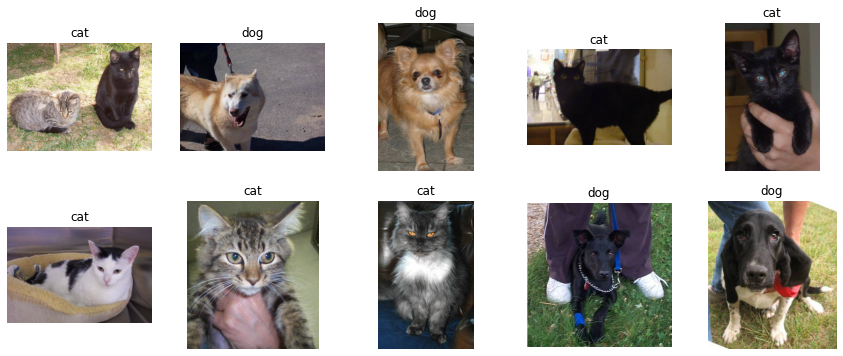

In [95]:
# get a sample of 5 randomly chosen pictures from each of small and tiny data
s_images = random.sample(glob.glob(parent_dir+"/"+"experiment_small_data"+"/train/*.jpg"),5)
t_images = random.sample(glob.glob(parent_dir+"/"+"experiment_tiny_data"+"/val/*.jpg"),5)

fig,ax = plt.subplots(2,5,figsize = (15,6))

#plot 
for path,axe in zip(s_images+t_images,ax.flatten()) : 
    label = path.split("/")[-1].split(".")[0]
    image = plt.imread(path)
    axe.imshow(image)
    axe.set_title(label)
    axe.axis("off")



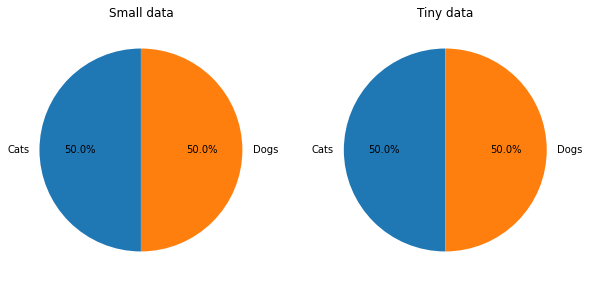

In [99]:
#Checking if the data is well balanced 

def get_proportions(folder_path): # returns a list of 2 values for dogs and cats amounts in folder
        data_dogs = 0
        data_cats = 0
        for file_path in glob.glob(parent_dir+"/"+folder_path+"/train/*.jpg"): # go though all jpg files in directory
                label = file_path.split("/")[-1].split(".")[0] #get label
                if label == "dog" : 
                        data_dogs += 1
                else : 
                        data_cats += 1 
        return [data_cats,data_dogs]

fig, ax = plt.subplots(1,2,figsize=(10,5))

# looping through axes and folder path as well as data name to plot the pie charts
for (folder_path, data_name), axe in zip([("experiment_small_data","Small data"),("experiment_tiny_data","Tiny data")],ax.flatten()):
        axe.pie(get_proportions(folder_path=folder_path), 
                labels=["Cats","Dogs"], 
                startangle=90, 
                autopct='%1.1f%%'
                )
        axe.set_title(data_name)

plt.show()

In [93]:
#creating the dataframes 

label_of = lambda x: x.split("/")[-1].split(".")[0] # return label from file path
small = "experiment_small_data"
tiny = "experiment_tiny_data"

def create_dataframe(folder,subfolder): # returns the dataframe from the images of a subfolder
    #create and shuffle the list of lists of file paths and labels before creating the dataframe
    data = shuffle([[file_path,1 if label_of(file_path)=="dog" else 0] for file_path in glob.glob(parent_dir+"/"+folder+"/"+subfolder+"/*.jpg")])
    df = pd.DataFrame(data,columns=["Path","Label"])
    return df

#storing all dataframes in a dictionary
df_dict = {}
for folder in [small,tiny]: 
    for subfolder in ["train","val","test"]: 
        df_dict[f"{folder}_{subfolder}_df"] = create_dataframe(folder,subfolder)

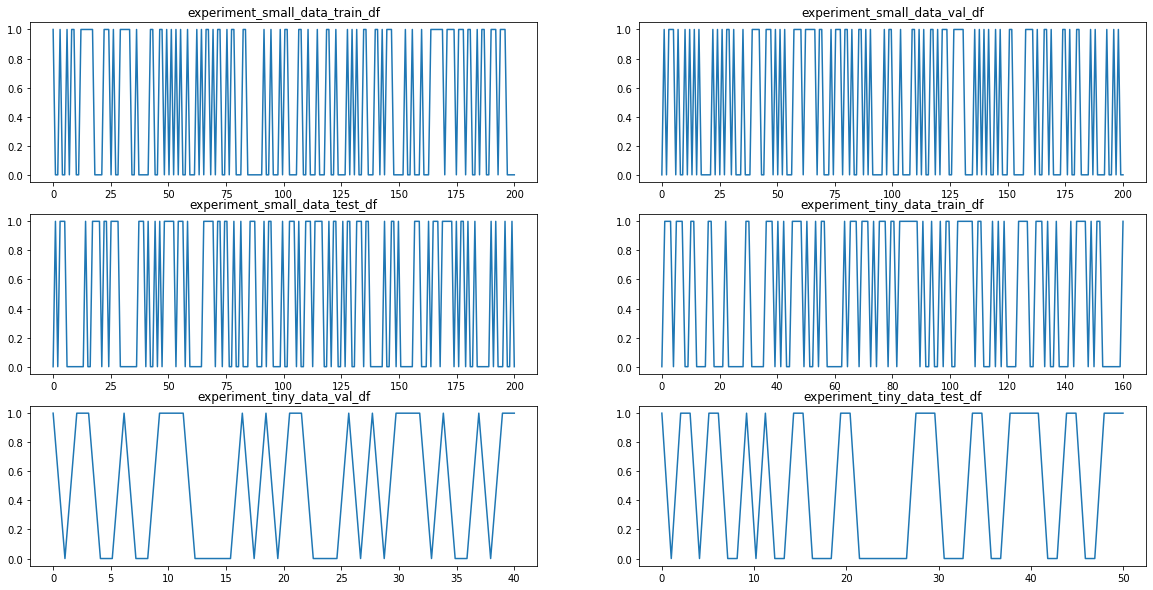

In [100]:
# we will plot the values and see if there is any long horizontal lines that 
# would mean our data is not well shuffled

fig,ax = plt.subplots(3,2,figsize=(20,10))

for key,axis in zip(df_dict,ax.flatten()) : 
    # for better visibily, we will plot a max of 200 points by dataframe
    y = df_dict[key].Label[:min(200,len(df_dict[key]))] 
    x = np.linspace(0,len(y),len(y))
    axis.plot(x,y) 
    axis.set_title(key)

plt.show()